In [ ]:
# Demonstrate a non-parametric (parzen) density estimator in 1D

# Author: Gerardo Durán Martín


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False


try:
    from probml_utils import savefig
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig


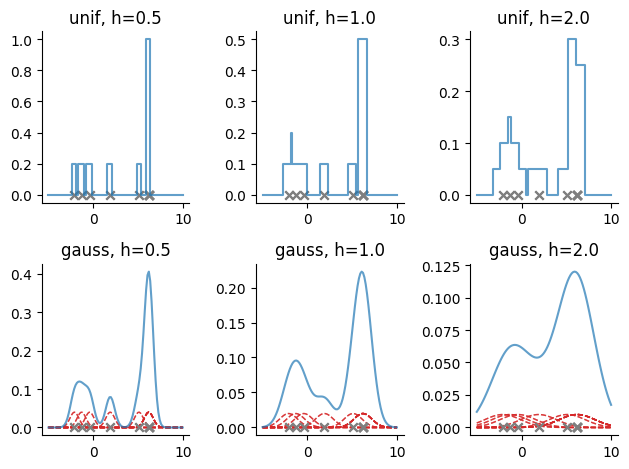

In [4]:
def K(u, axis=0):
    return np.all(np.abs(u) <= 1 / 2, axis=axis)


def p1(x, X, h):
    """
    KDE under a unit hypercube
    """
    N, D = X.shape
    xden, _ = x.shape

    u = ((x - X.T) / h).reshape(D, xden, N)
    ku = K(u).sum(axis=1) / (N * h**D)
    return ku


def kdeg(x, X, h, return_components=False):
    """
    KDE under a gaussian kernel
    """
    N, D = X.shape
    nden, _ = x.shape

    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    u = xhat - Xhat
    u = norm(u, ord=2, axis=0) ** 2 / (2 * h**2)  # (N, nden)
    px = np.exp(-u)
    if not return_components:
        px = px.sum(axis=1)

    px = px / (N * h * np.sqrt(2 * np.pi))
    return px


def main():
    data = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2, 6.2, 6.2, 6.2, 6.2,-2.1, -1.3, -0.4, 1.9, 5.1, 6.2, 6.2, 6.2, 6.2, 6.2 ])[:, None]
    yvals = np.zeros_like(data)
    xv = np.linspace(-5, 10, 100)[:, None]

    fig, ax = plt.subplots(2, 3)
    # Uniform h=1
    ax[0, 0].scatter(data, yvals, marker="x", c="tab:gray")
    ax[0, 0].step(xv, p1(xv, data, 0.5), c="tab:blue", alpha=0.7)
    ax[0, 0].set_title("unif, h=0.5")
    # Uniform h=2
    ax[0, 1].scatter(data, yvals, marker="x", c="tab:gray")
    ax[0, 1].step(xv, p1(xv, data, 1), c="tab:blue", alpha=0.7)
    ax[0, 1].set_title("unif, h=1.0")
    # Uniform h=2
    ax[0, 2].scatter(data, yvals, marker="x", c="tab:gray")
    ax[0, 2].step(xv, p1(xv, data, 2), c="tab:blue", alpha=0.7)
    ax[0, 2].set_title("unif, h=2.0")


    # Gaussian h=1
    ax[1, 0].scatter(data, yvals, marker="x", c="tab:gray", zorder=3)
    ax[1, 0].plot(xv, kdeg(xv, data, 0.5), c="tab:blue", alpha=0.7, zorder=2)
    ax[1, 0].plot(xv, kdeg(xv, data, 0.5, True), c="tab:red", alpha=0.7, linestyle="--", zorder=1, linewidth=1)
    ax[1, 0].set_title("gauss, h=0.5")
    # Gaussian h=1
    ax[1, 1].scatter(data, yvals, marker="x", c="tab:gray", zorder=3)
    ax[1, 1].plot(xv, kdeg(xv, data, 1), c="tab:blue", alpha=0.7, zorder=2)
    ax[1, 1].plot(xv, kdeg(xv, data, 1, True), c="tab:red", alpha=0.7, linestyle="--", zorder=1, linewidth=1)
    ax[1, 1].set_title("gauss, h=1.0")
    # Gaussian h=2
    ax[1, 2].scatter(data, yvals, marker="x", c="tab:gray", zorder=3)
    ax[1, 2].plot(xv, kdeg(xv, data, 2), c="tab:blue", alpha=0.7, zorder=2)
    ax[1, 2].plot(xv, kdeg(xv, data, 2, True), c="tab:red", alpha=0.7, linestyle="--", zorder=1, linewidth=1)
    ax[1, 2].set_title("gauss, h=2.0")

    plt.tight_layout()

    savefig("parzen_windows2.pdf", dpi=300)

    plt.show()


if __name__ == "__main__":
    main()

<ipython-input-5-7c1518c7c4d1>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ytrue = np.array([math.sin(abs(el)) / (abs(el)) for el in x]).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


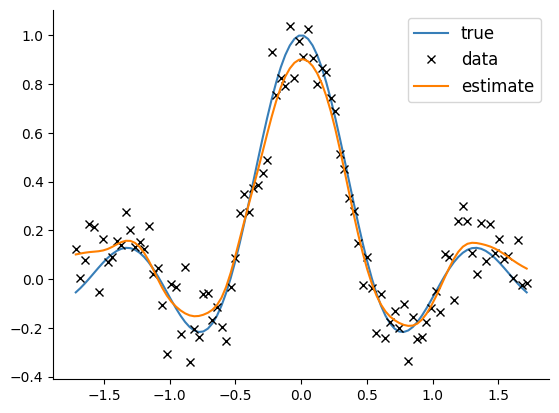

In [5]:
import numpy as np
from scipy.spatial.distance import cdist
import math
import matplotlib.pyplot as plt
try:
    from cycler import cycler
except ModuleNotFoundError:
    %pip install -qq cycler
    from cycler import cycler
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

CB_color = ['#377eb8', '#ff7f00', '#4daf4a']

cb_cycler = (cycler(linestyle=['-', '--', '-.']) * cycler(color=CB_color))
plt.rc('axes', prop_cycle=cb_cycler)

np.random.seed(0)
N = 100
x = 10 * (np.linspace(-1, 1, 100).reshape(-1, 1))
ytrue = np.array([math.sin(abs(el)) / (abs(el)) for el in x]).reshape(-1, 1)
noise = 0.1
y = ytrue + noise * np.random.randn(N, 1)
x = (x - x.mean()) / x.std()  # normalizing.


plt.plot(x, ytrue)
plt.plot(x, y, 'kx')


def rbf_features(X, centers, sigma):
    dist_mat = cdist(X, centers, 'minkowski', p=2.)
    return np.exp((-0.5 / (sigma ** 2)) * (dist_mat ** 2))


# Nadaraya-Watson Kernel Regressor
# using rbf kernel with autosSelected bandwidth given a range.
class NdwkernelReg:

    def __init__(self, gammas=None):
        self.gammas = gammas
        self.gamma = None

    def fit(self, X, y):
        self.X = X
        self.y = y

        self.gamma = self.select_gamma(self.gammas)

    def predict(self, X):
        K = rbf_features(self.X, X, self.gamma)
        return (K * self.y).sum(axis=0) / K.sum(axis=0)

    # leave-one-out crossValidation
    def select_gamma(self, gammas):
        mse = []

        for gamma in gammas:
            K = rbf_features(self.X, self.X, gamma)
            K = K - np.diag(np.diag(K))  # vanishing the diagonal elements
            y_pred = (K * self.y).sum(axis=0) / K.sum(axis=0)
            mse.append(((y_pred[:, np.newaxis] - self.y) ** 2).mean())

        return gammas[np.argmin(mse)]


nws = NdwkernelReg(gammas=np.linspace(0.1, 1, 10))
nws.fit(x, y)
y_estimate = nws.predict(x)
plt.plot(x, y_estimate)
plt.legend(['true', 'data', 'estimate'], fontsize=12)
pml.savefig("kernelRegressionDemo.pdf")
plt.show()

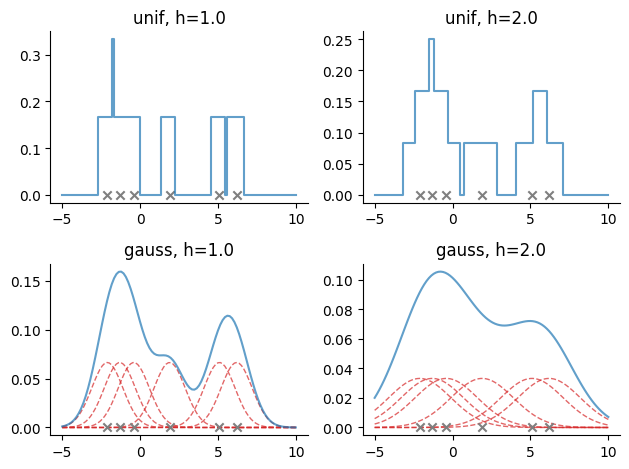

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False


try:
    from probml_utils import savefig
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig


def K(u, axis=0):
    return np.all(np.abs(u) <= 1 / 2, axis=axis)


def p1(x, X, h):
    """
    KDE under a unit hypercube
    """
    N, D = X.shape
    xden, _ = x.shape

    u = ((x - X.T) / h).reshape(D, xden, N)
    ku = K(u).sum(axis=1) / (N * h**D)
    return ku


def kdeg(x, X, h, return_components=False):
    """
    KDE under a gaussian kernel
    """
    N, D = X.shape
    nden, _ = x.shape

    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    u = xhat - Xhat
    u = norm(u, ord=2, axis=0) ** 2 / (2 * h**2)  # (N, nden)
    px = np.exp(-u)
    if not return_components:
        px = px.sum(axis=1)

    px = px / (N * h * np.sqrt(2 * np.pi))
    return px


def main():
    data = np.array([-2.1, -1.3, -0.4, 1.9, 5.1, 6.2])[:, None]
    yvals = np.zeros_like(data)
    xv = np.linspace(-5, 10, 100)[:, None]

    fig, ax = plt.subplots(2, 2)
    # Uniform h=1
    ax[0, 0].scatter(data, yvals, marker="x", c="tab:gray")
    ax[0, 0].step(xv, p1(xv, data, 1), c="tab:blue", alpha=0.7)
    ax[0, 0].set_title("unif, h=1.0")
    # Uniform h=2
    ax[0, 1].scatter(data, yvals, marker="x", c="tab:gray")
    ax[0, 1].step(xv, p1(xv, data, 2), c="tab:blue", alpha=0.7)
    ax[0, 1].set_title("unif, h=2.0")

    # Gaussian h=1
    ax[1, 0].scatter(data, yvals, marker="x", c="tab:gray", zorder=3)
    ax[1, 0].plot(xv, kdeg(xv, data, 1), c="tab:blue", alpha=0.7, zorder=2)
    ax[1, 0].plot(xv, kdeg(xv, data, 1, True), c="tab:red", alpha=0.7, linestyle="--", zorder=1, linewidth=1)
    ax[1, 0].set_title("gauss, h=1.0")
    # Gaussian h=2
    ax[1, 1].scatter(data, yvals, marker="x", c="tab:gray", zorder=3)
    ax[1, 1].plot(xv, kdeg(xv, data, 2), c="tab:blue", alpha=0.7, zorder=2)
    ax[1, 1].plot(xv, kdeg(xv, data, 2, True), c="tab:red", alpha=0.7, linestyle="--", zorder=1, linewidth=1)
    ax[1, 1].set_title("gauss, h=2.0")

    plt.tight_layout()

    savefig("parzen_windows2.pdf", dpi=300)

    plt.show()


if __name__ == "__main__":
    main()

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


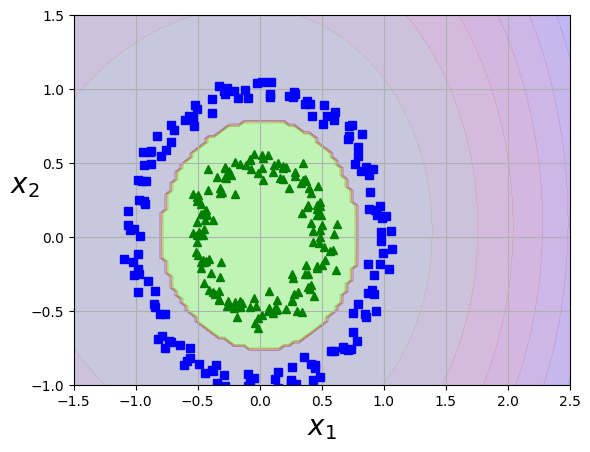

In [ ]:
# SVM for binary classification in 2d
# Code is based on
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb


import numpy as np
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    from sklearn.svm import SVC
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.svm import SVC
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs

from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True, which="both")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)


def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)


###

# Linear SVC with poly degree features

polynomial_svm_clf = Pipeline(
    [
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42)),
    ]
)

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.savefig("svm_classifier_moons_polynomial_preproc.pdf")
plt.show()


###
# RBF kernel with different hparams

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([("scaler", StandardScaler()), ("svm_clf", SVC(kernel="poly", gamma=gamma, C=C))])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

pml.savefig("svm_classifier_moons_rbf.pdf")
plt.show()